In [66]:
import requests
import base64
from bs4 import BeautifulSoup
import re

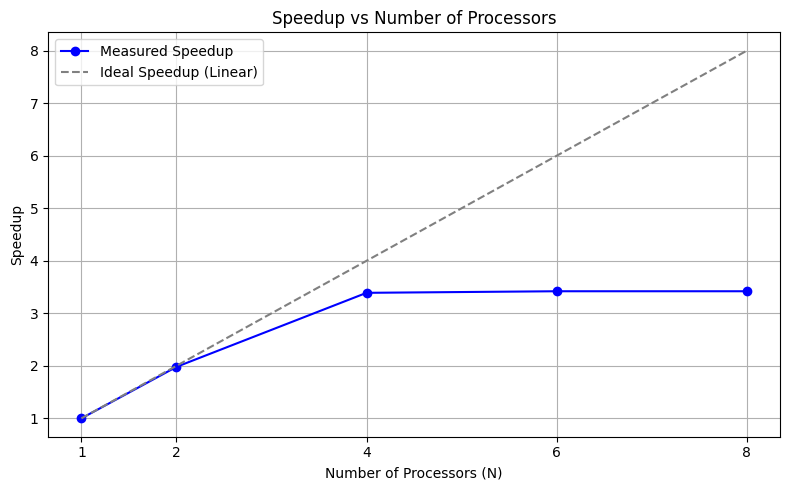

In [1]:
import matplotlib.pyplot as plt

# Number of processors
N = [1, 2, 4, 6, 8]

# Corresponding speedups
speedup = [1, 1.98, 3.39, 3.42, 3.42]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(N, speedup, marker='o', linestyle='-', color='blue', label='Measured Speedup')
plt.plot(N, N, linestyle='--', color='gray', label='Ideal Speedup (Linear)')  # Ideal linear speedup

# Labels and title
plt.title("Speedup vs Number of Processors")
plt.xlabel("Number of Processors (N)")
plt.ylabel("Speedup")
plt.grid(True)
plt.legend()
plt.xticks(N)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
# Spotify API credentials
CLIENT_ID = '' #Spotify API client ID
CLIENT_SECRET = '' #Spotify API client secret

In [2]:
# Get an access token
def get_access_token(client_id, client_secret):
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_header = base64.b64encode(f"{client_id}:{client_secret}".encode()).decode()
    headers = {
        'Authorization': f'Basic {auth_header}'
    }
    data = {
        'grant_type': 'client_credentials'
    }
    response = requests.post(auth_url, headers=headers, data=data)
    if response.status_code == 200:
        return response.json().get('access_token')
    else:
        print(f"Error getting access token: {response.status_code} - {response.text}")
        return None

In [ ]:
# Search for tracks from a specific year
def search_tracks(year, access_token):
    url = 'https://api.spotify.com/v1/search'
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    params = {
        'q': f'year:{year}',
        'limit': 50,
        'offset': 0,
        'type': 'track',  
        'market': 'US'  # should we keep this?
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error fetching tracks: {response.status_code} - {response.text}")
        return None

In [ ]:
# Search for the track ID by its name and its artist's name
def get_track_id(track_name, artist_name, access_token):
    url = 'https://api.spotify.com/v1/search'
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    params = {
        'q': f'track:{track_name} artist:{artist_name}', 
        'limit': 1,
        'type': 'track',  
        'market': 'US'  # should we keep this?
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        # Parse the response JSON
        search_results = response.json()
        # Get the track ID of the first search result
        if 'tracks' in search_results and search_results['tracks']['items']:
            track_id = search_results['tracks']['items'][0]['id']
            return track_id
        else:
            return None
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None


In [54]:
# Search for the artist ID by their name
def get_artist_id(artist_name, access_token):
    url = 'https://api.spotify.com/v1/search'
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    params = {
        'q': artist_name, 
        'limit': 1,
        'type': 'artist',  
        'market': 'US'  # should we keep this?
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        # Parse the response JSON
        search_results = response.json()
        # Get the track ID of the first search result
        if 'artists' in search_results:
            artist_id = search_results['artists']['items'][0]['id']
            return artist_id
        else:
            return None  # No artist found for the name
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

In [ ]:
def get_track_features(track_id, access_token):
    track_url = 'https://api.spotify.com/v1/tracks/{track_id}'
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    url = track_url.format(track_id=track_id)
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        # Parse the response JSON
        track_data = response.json()
        # Extracting features and storing them in a dictionary
        track_info = {
        'track_name': track_data['name'],
        'main_artist': track_data['artists'][0]['name'], # might remove this
        'all_artists': [],  
        'popularity': track_data['popularity'],
        'duration_ms': track_data['duration_ms'],
        'explicit': track_data['explicit'],
        'release_date': track_data['album']['release_date']
        }
        # to get all the artists featured on the song
        for artist in track_data['artists']:
            name=artist['name']
            track_info['all_artists'].append(name)

        return track_info

    else:
        print(f"Error: {response.status_code}, {response.text}")
        return 0

In [57]:
def get_artist_features(artist_id, access_token):
    url = 'https://api.spotify.com/v1/artists/{artist_id}'
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    url = url.format(artist_id=artist_id)
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        # Parse the response JSON
        artist_data = response.json()
        # Extracting features and storing them in a dictionary
        artist_info = {
        'artist_name': artist_data['name'],
        'genres': artist_data['genres'],
        'popularity': artist_data['popularity'],
        'followers': artist_data['followers']['total'],
        }
        return artist_info

    else:
        print(f"Error: {response.status_code}, {response.text}")
        return 0

In [ ]:
# MusicBrainz and AcouaticBrainz

def get_song_mbid(song_name, artist_name):
    url = 'https://musicbrainz.org/ws/2/recording/'
    params = {
        'query': f'recording:"{song_name}" artist:"{artist_name}"',
        'limit': 1,  
        'fmt': 'json'  
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        # Check if any results were returned
        if data['recordings']:
            # Get the MBID of the first recording result
            mbid = data['recordings'][0]['id']
            return mbid
        else:
            print("Song not found.")
            return None
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

In [108]:
def get_audio_features(mbid):
    url = f'https://acousticbrainz.org/api/v1/{mbid}/low-level'
    
    url = url.format(mbid=mbid)
    response = requests.get(url)
    if response.status_code == 200:
        # Return the low-level audio features as a JSON dictionary
        return response.json()
    else:
        print(f"Error {response.status_code}: {response.text}")
        return None

In [ ]:
def get_audio_features(track_id, access_token):
    track_url = 'https://api.spotify.com/v1/audio-features/{track_id}'
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    url = track_url.format(track_id=track_id)
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        # Parse the response JSON
        audio_features = response.json()
        print("response is: ", response)

        audio_info = {
        'danceability': audio_features['danceability'],
        'energy': audio_features['energy'], 
        'loundness': audio_features['loudness'],
        'accousticness': audio_features['acousticness'],
        'instrumentalness': audio_features['instrumentalness'],
        'liveness': audio_features['liveness'],
        'tempo': audio_features['tempo'],
        'valence': audio_features['valence'],
        'key': audio_features['key'],
        'mode': audio_features['mode'],
        'speechiness': audio_features['speechiness'],
        'time_signature': audio_features['time_signature']
        }
        # +genre from acousticbrainz
        
        return audio_info
    else:
        print(f"Error: {response.status_code}, {response.text}")  
        return 0  

In [ ]:
# Step 3: Process and display the results
def display_tracks(data):
    if data and 'tracks' in data:
        tracks = data['tracks']['items']
        for track in tracks:
            name = track['name']
            artist = track['artists'][0]['name']
            album = track['album']['name']
            print(f"Track: {name}, Artist: {artist}, Album: {album}")
    else:
        print("No tracks found.")

# Genius API

In [ ]:
# Access token

access_token= ""
base_url = "https://api.genius.com"

In [64]:
# Getting lyrics from genius API using song name and artist name
def search_track_genius(track_name, artist_name):
    search_url = base_url + "/search"
    query = f"{track_name} {artist_name}" 
    params = {'q': query}
    headers = {'Authorization': 'Bearer ' + access_token}
    
    response = requests.get(search_url, params=params, headers=headers)
    
    if response.status_code == 200:
        return response.json()['response']['hits'][0]['result']['id']
    else:
        return None

def get_lyrics_url(track_id):
    song_url = f"{base_url}/songs/{track_id}"
    headers = {'Authorization': 'Bearer ' + access_token}
    
    response = requests.get(song_url, headers=headers)
    
    if response.status_code == 200:
        song_info = response.json()['response']['song']
        lyrics_path = song_info['path']
        return "https://genius.com" + lyrics_path
    else:
        print("Error fetching song details:", response.status_code)
        return None

import time

def get_lyrics(lyrics_url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36'
    }
    response = requests.get(lyrics_url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')        

        lyrics_div = soup.find_all('div', {'data-lyrics-container': 'true'})
        
        if lyrics_div:
            lyrics=""
            for ly in lyrics_div:
                lyr=ly.get_text(separator=" ")
                # print("\n"+lyr)
                lyr=lyr.strip()
                lyrics=lyrics+" "+lyr
            return lyrics

        else:
            print("Lyrics not found on the page.")
            return None
    else:
        print("Error fetching page content:", response.status_code)
        return None    
    
def clean_lyrics(lyrics):
    result = re.sub(r'\[.*?\]', '', lyrics)
    return result.strip()
    


In [69]:
# trial of genius:

song_id=search_track_genius("Full Stop", "IU")
url=get_lyrics_url(song_id)
lyrics=get_lyrics(url)
lyrics_cleaned=clean_lyrics(lyrics)
print(lyrics_cleaned)

알고 있었어 무슨 말인지 무슨 마음인지 다 알아 하루 더 딱 하루만 더 미루고 싶었어  그래야겠지 결국 언젠간 제일 어려운 숙제를 해야지 마지막 인사가 이렇게 늦어서 미안  많이 보고 싶지만 널 다시는 만나지 않았음 좋겠어 아파 울지만 다신 너로 인해 웃지 않았음 좋겠어 한 움큼씩 나눴던 진심도 너무 쉬웠던 대답도 못 잊게 사랑한 여러 번의 계절도 안녕 모두 안녕  전부 알 것 같아도 더 이상의 이해는 없었음 좋겠어 묻고 싶지만 끝내 그 대답을 듣지 못했음 좋겠어 변함없이 정직한 두 눈도 약속한 겨울바다도 못 잊게 행복했던 어린 날의 나도 안녕 모두 안녕  안녕 모두


In [ ]:
def main():
    # Get access token
    access_token = get_access_token(CLIENT_ID, CLIENT_SECRET)
    if not access_token:
        return

    # Search for tracks from the year 2017
    year = 2017
    data = search_tracks(year, access_token)
    if data:
        display_tracks(data)

In [ ]:
main()

# Testing

In [ ]:
# trial
access_token=get_access_token(CLIENT_ID, CLIENT_SECRET)

In [25]:
track_id=get_track_id("Can't Remember to Forget You", "Shakira", access_token)
print("the track id is: ", track_id)

the track id is:  7o1Pm9jpH0wFpN5g793Lnq


In [43]:
track_features=get_track_features(track_id, access_token)
print(track_features)

{'track_name': "Can't Remember to Forget You (feat. Rihanna)", 'main_artist': 'Shakira', 'all_artists': ['Shakira', 'Rihanna'], 'popularity': 75, 'duration_ms': 206866, 'explicit': False, 'release_date': '2014-03-13'}


In [41]:
print(track_id)
audio_features= get_audio_features(track_id, access_token)
print(audio_features)

7o1Pm9jpH0wFpN5g793Lnq
Error: 403, {
  "error" : {
    "status" : 403
  }
}
0


In [58]:
artist_id=get_artist_id('Ed Sheeran', access_token)
print(artist_id)
print(get_artist_features(artist_id, access_token))


6eUKZXaKkcviH0Ku9w2n3V
{'artist_name': 'Ed Sheeran', 'genres': ['soft pop'], 'popularity': 86, 'followers': 119016545}


In [ ]:
# musicbrainz and acousticbrainz testing
mbid=get_song_mbid('Bohemian Rhapsody', 'Queen')
print(mbid)
# print(get_audio_features(mbid))

Features we want to extract:
high level (track details): name of track, artists name, popularity (score from 0 to 100), duration_ms, explicit, release_date(from the album info inside the track info, might not be available if track was not released in any album though most of the time even if the track was released as a single it will be part of an album that contains only it) 

NOTE: genre of track is not available. only the genres of the artist who sang the track

Possible Solution for release_date and genre: MusicBrainz

low level (audio details): 
danceability, energy, loudness, acousticness, instrumentalness, tempo, valence, speechiness

In [ ]:
# extracting the track name and artist name from the list of the Billboard Hit songs , getting their track IDs, and retrieving all the features of those tracks that we are interested in.